# Predicting Whether an Instagram Account is Fake or Genuine

Author: *Khoi Ngo*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Overview of Steps to Accomplish Notebook

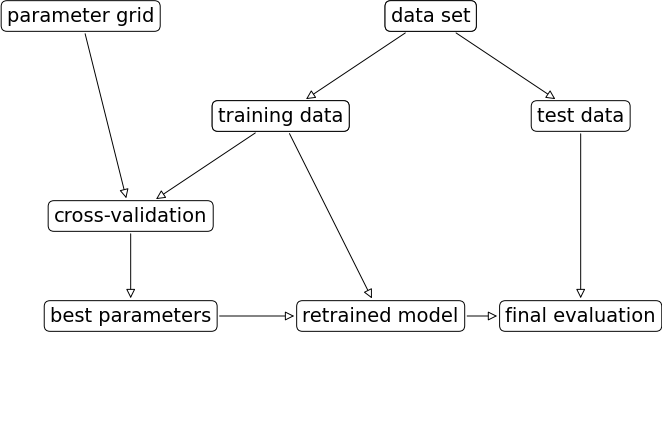

In [2]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function Definitions

In [60]:
from sklearn.datasets import load_files

def load_train_data():
    ''' Load data from csv files, Train data 
        Splits data into X (feature matrix) and y (labels)
        
        returns: X_train, y_train, X_test, y_test
        
    '''
    train_data = pd.read_csv('data/train.csv', header = 0)
    
    X_train = train_data.drop(columns='fake')
    y_train = train_data['fake']
    
    return X_train, y_train

In [61]:
from sklearn.datasets import load_files

def load_test_data():
    ''' Load data from csv files, Train and Test data 
        Splits data into X (feature matrix) and y (labels)
        
        returns: X_train, y_train, X_test, y_test
        
    '''
    test_data = pd.read_csv('data/test.csv', header = 0)
    
    X_test = test_data.drop(columns='fake')
    y_test = test_data['fake']
    
    return X_test, y_test

In [4]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    train_scores = scores['train_score']
    val_scores = scores['test_score']
    
    train_mean = np.mean(train_scores)
    val_mean = np.mean(val_scores)
    
    return train_mean, val_mean

In [5]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
    
     #TODO: implement function body
    
    print(grid_search.best_params_)
    
    best_train = grid_search.cv_results_["mean_train_score"][grid_search.best_index_]
    print("best mean_train_score: {:.3f}".format(best_train))
        
    best_test = grid_search.cv_results_["mean_test_score"][grid_search.best_index_]
    print("best mean_test_score: {:.3f}".format(best_test))

In [6]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [7]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    data = confusion_matrix(y_actual, y_pred)
    ax = sns.heatmap(data,
                     annot=True,
                     cbar=False,
                     fmt='d',
                     xticklabels = labels,
                     yticklabels = labels)
    ax.set_title(title)
    ax.set_xlabel("predicted values")
    ax.set_ylabel("actual values")

## 1. Load Data

In [69]:
X_data, y_data = load_train_data()
print(X_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 49.6 KB
None


In [76]:
X_data.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.27,0,0.0,0,53,0,0,32,1000,955
1,1,0.00,2,0.0,0,44,0,0,286,2740,533
2,1,0.10,2,0.0,0,0,0,1,13,159,98
3,1,0.00,1,0.0,0,82,0,0,679,414,651
4,1,0.00,2,0.0,0,0,0,1,6,151,126


In [70]:
print("Size: ",X_data.shape, ", Type: ", type(X_data))
print("Size: ",y_data.shape, ", Type: ", type(y_data))

Size:  (576, 11) , Type:  <class 'pandas.core.frame.DataFrame'>
Size:  (576,) , Type:  <class 'pandas.core.series.Series'>


## 2. Inspect Data

In [79]:
print(X_train.isnull().sum())

profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
dtype: int64


In [71]:
unique, freq = np.unique(y_train, return_counts = True) 

for i, j in zip(unique, freq):
    print("Label: ", i, ", Frequency: ", j)

Label:  0 , Frequency:  233
Label:  1 , Frequency:  227


## 3. Create training and test sets

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=37)

In [73]:
print(X_train.shape)
print(y_train.shape)

(460, 11)
(460,)


## 4. Compare Models Using Cross-Validation

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

model_list = [LogisticRegression(max_iter=600),
              SVC(), 
              GaussianNB(),
              RandomForestClassifier(random_state=55),
              GradientBoostingClassifier(random_state=56)]

train_scores = []
val_scores = []

for model in model_list:
    train, val = get_classifier_cv_score(model, X_train, y_train,'average_precision')
    train_scores.append(train)
    val_scores.append(val)
    
models_score = sorted(list(zip(val_scores, train_scores, model_list)), reverse=True)

print("-------------------------------------")
for val, train, model in models_score:
    print("Model: {} ".format(model.__class__.__name__))

    print("train_score: {:.3f}".format(train)) 

    print("validation_score: {:.3f}".format(val)) 

    print("-------------------------------------")

-------------------------------------
Model: RandomForestClassifier 
train_score: 1.000
validation_score: 0.984
-------------------------------------
Model: GradientBoostingClassifier 
train_score: 1.000
validation_score: 0.979
-------------------------------------
Model: LogisticRegression 
train_score: 0.980
validation_score: 0.975
-------------------------------------
Model: SVC 
train_score: 0.929
validation_score: 0.928
-------------------------------------
Model: GaussianNB 
train_score: 0.804
validation_score: 0.821
-------------------------------------


## 5. Hyperparameter Tuning Using Grid Search

### 5.1 Grid Search for RandomForestClassifier

In [84]:
from sklearn.model_selection import GridSearchCV
import os
num_cpu = int(os.environ['NUMBER_OF_PROCESSORS'])

model = RandomForestClassifier(random_state=55)

parameters = {'n_estimators': [300, 500, 700, 1000],
              'max_depth': [7, 9, 11, 13]}

grid1 = GridSearchCV(model, parameters, cv=7, scoring='average_precision', n_jobs=num_cpu, return_train_score=True)

In [85]:
grid1.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=12,
             param_grid={'max_depth': [7, 9, 11, 13],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, scoring='average_precision')

In [86]:
print_grid_search_result(grid1)

{'max_depth': 7, 'n_estimators': 700}
best mean_train_score: 1.000
best mean_test_score: 0.985


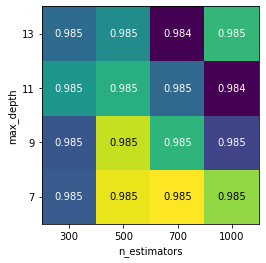

In [88]:
plot_grid_search_results(grid1)

### 5.2 Grid Search for Gradient Boosting Classifier

In [89]:
model = GradientBoostingClassifier(max_depth=5, random_state=56)

parameters = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]}

grid2 = GridSearchCV(model, parameters, cv=7, scoring='average_precision', n_jobs=num_cpu, return_train_score=True)

In [90]:
grid2.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=12,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [91]:
print_grid_search_result(grid2)

{'learning_rate': 1.0, 'n_estimators': 50}
best mean_train_score: 1.000
best mean_test_score: 0.981


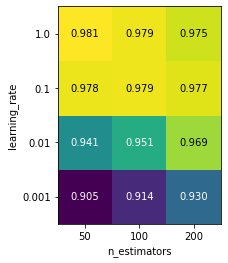

In [92]:
plot_grid_search_results(grid2)

### 5.3 Grid Search for Logistic Regression

In [104]:
model = LogisticRegression(max_iter=1000)

parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.01, 0.1, 1.0, 10.0]}

grid3 = GridSearchCV(model, parameters, cv=7, scoring='average_precision', n_jobs=num_cpu, return_train_score=True)

In [105]:
grid3.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(max_iter=1000), n_jobs=12,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True, scoring='average_precision')

In [106]:
print_grid_search_result(grid3)

{'C': 10.0, 'penalty': 'l2'}
best mean_train_score: 0.984
best mean_test_score: 0.978


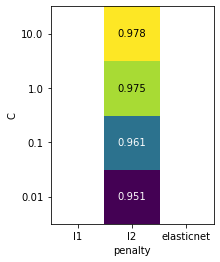

In [103]:
plot_grid_search_results(grid3)